In [3]:
from ggplot import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

%matplotlib inline

In [2]:
df_2015 = pd.read_csv('../raw_data/2015_WH_pay_links_merged_edited.csv')
df_2015.loc[df_2015.Gender=='?','Gender'] = np.nan
df_2015 = df_2015[ pd.notnull(df_2015['Gender']) ]

df_long = pd.read_csv('../raw_data/combined_wh_pay.csv')
df_long['Name'] = df_long['Name'].str.strip()
df_long = df_long[ df_long.Status != "Employee (part-time)"]

df_long.loc[ df_long.Gender =='?', 'Gender'] = np.nan
df_long.loc[ df_long.Salary ==0, 'Gender'] = np.nan
df_long = df_long.dropna()

In [4]:
color_list = [
    '#CC6699',
    '#008AB8', 
    '#c760ff', 
    '#f43605', 
    '#00FF00',
    '#0000FF', 
    '#4c9085'
]

In [32]:
f = df_2015[ (df_2015.Salary <= 60000) & (df_2015.Est_Age != 'unknown')].Est_Age
np.mean(f.astype(int))

26.052238805970148

### Save 2015 WH Data

In [12]:
dropped_unknown = df_2015[ df_2015.Est_Age != 'unknown']
dropped_unknown.to_csv('df2015_forR.csv')

### Process the data and generate 6 yr outcome csv

In [13]:
def find_yrs_served_5yr(x, year):
    yr_list = x[ x.Year <= year+5 ].Year
    return len(yr_list)

def find_max_5yr_salary(x, year):
    subdf = x[ x.Year <= year+5 ]
    return max(subdf.Salary)

def find_yrs_elapsed_5yr(x, year):
    subdf = x[ x.Year <= year+5 ]
    return max(subdf.Year) - min(subdf.Year)

def find_dSalary(x, year):
    #Finds the rate increase between the first and last years
    
    subdf = x[ x.Year <= year+5 ]
    minyr = min(subdf.Year)
    maxyr = max(subdf.Year)
    
    dSalary = subdf[ subdf.Year==maxyr ].Salary.values[0] - subdf[ subdf.Year==minyr ].Salary.values[0]
    return dSalary/float(maxyr - minyr)
    

In [370]:
#Create data for longitudinal study
sal_cutoff = 60000

df_list = []

for year in range(2009, 2011):
    grouped = df_long.groupby("Cleaned_Name")
        
    # Find individuals that started in that year and salary < cutoff
    grouped = grouped.filter( lambda x: min(x.Year) == year ).groupby("Cleaned_Name")
    grouped = grouped.filter( lambda x: x[x.Year == year].Salary < sal_cutoff ).groupby('Cleaned_Name')
    
    max_5yr_salary = grouped.apply( lambda x: find_max_5yr_salary(x, year) )
    years_served_5yr = grouped.apply( lambda x: find_yrs_served_5yr(x, year) )
    years_elapsed_5yr = grouped.apply(lambda x: find_yrs_elapsed_5yr(x, year) ) + 1
    dSalary = grouped.apply(lambda x: find_dSalary(x, year)).fillna(0)
    gender = grouped.apply(lambda x: x.Gender.values[0])
    
    tempdf = pd.concat([max_5yr_salary, dSalary, years_served_5yr, years_elapsed_5yr, gender], axis=1)
    df_list.append(tempdf)

    
newdf = pd.concat(df_list)
newdf.columns = ['Y6_Max_Salary', 'Y6_dSalary', 'Y6_Served', 'Y6_Elapsed', 'Gender']
newdf.to_csv('../proc_data/six_year_outcomes_60.csv')

### Table and Figure for salaries

In [6]:
bins = np.linspace(df_2015.Salary.min(), df_2015.Salary.max(), 20)
groups = df_2015.groupby(np.digitize(df_2015.Salary, bins))
sex_count = pd.DataFrame(groups['Gender'].value_counts(), columns=['Quantity'])

In [7]:
newdf = df_2015
sal_cutoff = 80000


newdf['Salary_Category'] = '$150k+'
newdf.loc[ (newdf.Salary > sal_cutoff) & (newdf.Salary<140000), 'Salary_Category'] = '$150 - 80k'
newdf.loc[ newdf.Salary < sal_cutoff, 'Salary_Category'] = '0 - $80k'
    
merged = newdf.groupby(['Salary_Category', 'Gender']).agg([np.mean, np.median, len])
merged = merged.sort([('Salary', 'mean')], ascending=False)

In [1]:
from IPython.display import display, HTML 
import re

merged['Salary','mean'] = merged['Salary','mean'].astype(int)
merged = merged.rename(columns = {'newname':'# of employees'})
htmltxt = merged.to_html()
htmltxt = re.sub('len', 'n', htmltxt)
display(HTML(htmltxt)) 

NameError: name 'merged' is not defined

In [364]:
diffs = [1.110908, 54020/54634., 113359/109885., 155412/154491.]
diffs = np.multiply(np.subtract(diffs, 1), 100)
category = ['All', '<$80k', '$150-80k', '$150k+']
newdf = pd.DataFrame({'Diff':diffs, 'Category':category})

lbls = [x + '%' for x in map(str,range(-2,12,2))]

p = ggplot(newdf, aes('Category','Diff'))\
+ geom_bar(stat='identity', fill="gray", colour="gray")\
+ scale_y_continuous(breaks=range(-2,12,2), labels=lbls)\
+ ylab("Gender Pay Gap")\
+ xlab("Salary Range")\
+ ggtitle('Gender Pay Gap by Salary Range')


ggsave(p, '../figs/percent_difference.png')

Saving 11.0 x 8.0 in image.


### What salaries do newcomers make?

In [34]:
data = []
for year in range(2009, 2011):
    grouped = df_long.groupby("Cleaned_Name")
    grouped = grouped.filter( lambda x: min(x.Year) == year).groupby("Cleaned_Name")
    data.append( grouped.apply( lambda x: x[ x.Year == year ].Salary) )
new_salaries = reduce(pd.Series.append, data)

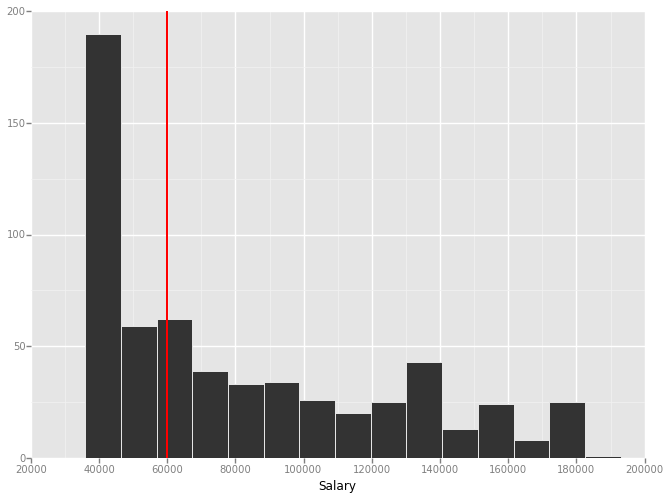

<ggplot: (289312917)>

In [35]:
newdf = new_salaries.to_frame()
ggplot(newdf, aes('Salary')) + geom_histogram(binwidth=10000)\
+ geom_vline(xintercept=60000, size=2, color='red')

### Save Rentention Data to csv

In [53]:
sal_cutoff = 60000

def get_quit_jr(x, year):
    #Is employee not in current year?

    if np.any(x.Year.isin([year])):
        this_year = True
    else:
        this_year = False
        
    jr_before = False
    if np.any(x.Year.isin([year-1])):
        jr_before = x[x.Year == year-1].Salary < sal_cutoff

    return (not this_year) and jr_before

#Promoted is defined as anyone promoted that was in a junior position prior
def get_promote_jr(x, year):
    #Is current year salary < cutoff
    this_year = False
    if np.any(x.Year.isin([year])):
        this_year = x[x.Year == year].Salary >= sal_cutoff 
        this_year = this_year.values[0]

    #Find prior year
    yrs = x.Year.values - year
    yrs = yrs[yrs<0]
    jr_before = False    
    if yrs.size > 0:
        prior_year = max(yrs) + year
        jr_before = x[x.Year == prior_year].Salary < sal_cutoff

    return (this_year and jr_before)
    
#Returning is defined as anyone that is returning to the administration at a junior level    
def get_return_jr(x, year):
    #Is current year salary < cutoff
    this_year = False
    if np.any(x.Year.isin([year])):
        this_year = x[x.Year == year].Salary < sal_cutoff 
        this_year = this_year.values[0]

    #Find prior year
    yrs = x.Year.values - year
    yrs = yrs[yrs<0]
    jr_before = False    
    if yrs.size > 0:
        prior_year = max(yrs) + year
        jr_before = x[x.Year == prior_year].Salary < sal_cutoff

    return (this_year and jr_before)


#Returning is defined as anyone that is returning to the administration at any level    
def get_return_all(x, year):
    #Is current year salary < cutoff
    this_year = False
    if np.any(x.Year.isin([year])):
        this_year = True

    #Find prior year
    yrs = x.Year.values - year
    yrs = yrs[yrs<0]
    jr_before = False    
    if yrs.size > 0:
        prior_year = max(yrs) + year
        jr_before = x[x.Year == prior_year].Salary < sal_cutoff

    return (this_year and jr_before)



def get_total_jr(x, year):
    temp = x[x.Year == year].Salary < sal_cutoff
    return temp.values[0]

def get_new_jr(x, year):
    return (min(x.Year) == year) and (x[x.Year == year].Salary < sal_cutoff)

def return_df(grouped, year, kind):
    genlist = grouped.apply(lambda x: x.Gender.values[0])
    genders = genlist.value_counts().index
    counts = genlist.value_counts().values
    df = pd.DataFrame({'Gender':genders, 'Count':counts, 'Type':[kind]*2, 'Year':[year]*2})
    return df
    

In [54]:
names_grouped = df_long.groupby('Cleaned_Name')
yrs_grouped = df_long.groupby('Year')

reten_data = pd.DataFrame(columns=['Year','Type','Gender','Count'])

for year in range(2010, 2016):
    yr_group = yrs_grouped.get_group(year)
    jr = yr_group[ yr_group.Salary < sal_cutoff]
    fem, male = jr.Gender.value_counts()[:]
    tempdf = pd.DataFrame({'Year':[year]*2, 'Type':['Total']*2, 'Gender':['female','male'], 'Count':[fem,male]})
    reten_data = reten_data.append(tempdf)

    new_jr = names_grouped.filter( lambda x: get_new_jr(x, year) )
    new_jr = new_jr.groupby('Cleaned_Name')
    reten_data = reten_data.append( return_df(new_jr, year, 'New') )

    return_all = names_grouped.filter( lambda x: get_return_all(x,year) ) 
    return_all = return_all.groupby('Cleaned_Name')
    reten_data = reten_data.append( return_df(return_all, year, 'Return_All') )

    return_jr = names_grouped.filter( lambda x: get_return_jr(x,year) )
    return_jr = return_jr.groupby('Cleaned_Name')
    reten_data = reten_data.append( return_df(return_jr, year, 'Returning') )    
    
    prom_jr = names_grouped.filter( lambda x: get_promote_jr(x,year) )
    prom_jr = prom_jr.groupby('Cleaned_Name')
    reten_data = reten_data.append( return_df(prom_jr, year, 'Promoted') )    
    
    quit_jr = names_grouped.filter( lambda x: get_quit_jr(x, year))
    quit_jr = quit_jr.groupby('Cleaned_Name')
    reten_data = reten_data.append( return_df(quit_jr, year, 'Quit') )    
    
    print year, 'quit:',len(quit_jr), 'ret:',len(return_jr), 'new:',len(new_jr), 'prom:',len(prom_jr), 'total:', len(jr)

2010 quit: 51 ret: 125 new: 58 prom: 29 total: 183
2011 quit: 74 ret: 86 new: 91 prom: 24 total: 177
2012 quit: 60 ret: 96 new: 83 prom: 22 total: 180
2013 quit: 42 ret: 127 new: 43 prom: 16 total: 170
2014 quit: 60 ret: 97 new: 72 prom: 18 total: 170
2015 quit: 54 ret: 91 new: 83 prom: 28 total: 174


In [55]:
reten_data.to_csv('../proc_data/reten_data_60.csv')

In [1]:
print reten_data.Type.value_counts()
ggplot(reten_data[reten_data.Type=='Total'], aes('Year','Count',color='Gender'))\
+ geom_line(size=3)\
+ scale_colour_manual(values=color_list)\
+ scale_x_continuous(limits = (2010,2015), breaks = range(2010,2016), labels=range(2010,2016))\
+ scale_y_continuous(limits = (50,200))\
+ ggtitle('Number of Junior Employees')

#ggsave(p, '../figs/num_jr_emp_fig.png')

NameError: name 'reten_data' is not defined

In [52]:
#Find all people by gender that had salary < X and served only one year
# year by year.
from collections import Counter

s = [] 
grouped = df_long.groupby('Cleaned_Name')
for year in range(2009,2011):
    p = grouped.filter(lambda x: (len(x)==1) and (x.Year.values[0]==year) and (x.Salary.values[0]<60000))
    f = Counter(p.Gender.get_values())
    print f
    s.append(f.values())

Counter({'female': 32, 'male': 13})
Counter({'male': 8, 'female': 7})


In [39]:
s[4] = [0,4]

In [40]:
s

[[13, 32], [8, 7], [6, 15], [8, 9], [0, 4], [10, 15], [34, 49]]

In [50]:
f = sum([ x[1] for x in s])
m = sum([ x[0] for x in s])
print m, f

79 131
